<a href="https://colab.research.google.com/github/sanghoonsim/EEE511-Artificial-Neural-Computation/blob/main/Team18_Sim_progress_check_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download Flickr8k and unzip
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXVy7_7pF5FIsPp6WfXXfWgBNfUKx8N1VrTisN8FbGYG9w?download=1 -O Flickr8k_dataset.zip

--2021-10-07 21:38:47--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXVy7_7pF5FIsPp6WfXXfWgBNfUKx8N1VrTisN8FbGYG9w?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/Flickr8k_dataset.zip?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWFZ5N183cEY1RklzUHA2V2ZYWGZXZ0JOZlVLeDhOMVZyVGlzTjhGYkdZRzl3P3J0aW1lPXV1NUQyZHFKMlVn [following]
--2021-10-07 21:38:49--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/Flickr8k_dataset.zip?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWFZ5N183cEY

In [2]:
%%capture
!unzip Flickr8k_dataset.zip -d ./Flickr8k_dataset

In [3]:
# Install library to calculate BLEU Score
!pip install torchtext==0.6.0

     |████████████████████████████████| 64 kB 2.0 MB/s 
     |████████████████████████████████| 1.2 MB 10.7 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0


In [4]:
# Resize all the images in the dataset
import os
from PIL import Image

image_dir = "./Flickr8k_dataset/Images" # Path to original image
train_image_dir = "./resized_train/images" # Path to resized image(Training)
val_image_dir = "./resized_val/images" # Path to resized image(Validation)
test_image_dir = "./resized_test/images" # Path to resized image(Testing)
size = [256, 256] # size of resized image


def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

# Move the resized image in the image_dir to the result folder(Learning, Validation and Testing)
if not os.path.exists(train_image_dir):
    os.makedirs(train_image_dir)
if not os.path.exists(val_image_dir):
    os.makedirs(val_image_dir)
if not os.path.exists(test_image_dir):
    os.makedirs(test_image_dir)

images = sorted(os.listdir(image_dir)) # Sorting both image and caption by name
num_images = len(images)
num_train_images = 6000 # 6000 for Learning data
num_val_images = 1000 # 1000 for validation

for i, image in enumerate(images):
    if (i + 1) <= num_train_images:
        output_dir = train_image_dir
    elif (i + 1) <= num_train_images + num_val_images:
        output_dir = val_image_dir
    else:
        output_dir = test_image_dir
    with open(os.path.join(image_dir, image), 'rb+') as f:
        with Image.open(f) as img:
            img = resize_image(img, size)
            img.save(os.path.join(output_dir, image), img.format)
    if (i + 1) % 500 == 0:
        print(f"[{i + 1}/{num_images}] Resized the images and saved into '{output_dir}'")

[500/8091] Resized the images and saved into './resized_train/images'
[1000/8091] Resized the images and saved into './resized_train/images'
[1500/8091] Resized the images and saved into './resized_train/images'
[2000/8091] Resized the images and saved into './resized_train/images'
[2500/8091] Resized the images and saved into './resized_train/images'
[3000/8091] Resized the images and saved into './resized_train/images'
[3500/8091] Resized the images and saved into './resized_train/images'
[4000/8091] Resized the images and saved into './resized_train/images'
[4500/8091] Resized the images and saved into './resized_train/images'
[5000/8091] Resized the images and saved into './resized_train/images'
[5500/8091] Resized the images and saved into './resized_train/images'
[6000/8091] Resized the images and saved into './resized_train/images'
[6500/8091] Resized the images and saved into './resized_val/images'
[7000/8091] Resized the images and saved into './resized_val/images'
[7500/8091]

In [5]:
# Build vocabs using captions
import pickle
import nltk
from collections import Counter

nltk.download('punkt')

caption_path = "./Flickr8k_dataset/captions.txt" # Original caption file
vocab_path = "./vocab.pkl" # vocabs
word_threshold = 4 # the minumum nuber of appearance
train_caption_path = "./resized_train/captions.txt" # Path to captions of resized image(Training)
val_caption_path = "./resized_val/captions.txt" # Path to captions of resized image(Validation)
test_caption_path = "./resized_test/captions.txt" # Path to captions of resized image(Testing)


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

counter = Counter()

with open(caption_path, "r") as f:
    lines = sorted(f.readlines()[1:])
    for i in range(len(lines)):
        line = lines[i]
        if (i + 1) <= num_train_images * 5: # 5 captions per image
            output_caption = train_caption_path
        elif (i + 1) <= (num_train_images + num_val_images) * 5:
            output_caption = val_caption_path
        else:
            output_caption = test_caption_path
        index = line.find(",") # Find the starting point of caption
        caption = line[index + 1:] # Recording character of captions
        tokens = nltk.tokenize.word_tokenize(caption.lower()) # Tokenization
        counter.update(tokens) # Count token
        with open(output_caption, "a") as output_caption_f:
            output_caption_f.write(line)

# only if when it surpass the threshold
words = [word for word, cnt in counter.items() if cnt >= word_threshold]

vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>') # unknown

# assign all the words to Vocabulary object
for word in words:
    vocab.add_word(word)

# Save vocabulary
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
# The number of captions(Training) in dataset
!wc -l ./resized_train/captions.txt
# The number of captions(Val) in dataset
!wc -l ./resized_val/captions.txt
# The number of captions(Testing) in dataset
!wc -l ./resized_test/captions.txt

30000 ./resized_train/captions.txt
5000 ./resized_val/captions.txt
5455 ./resized_test/captions.txt


In [7]:
# Define Flickr8kDataset Class
import torch.utils.data as data

class Flickr8kDataset(data.Dataset):
    def __init__(self, root, captions, vocab, transform=None):
        self.root = root # Path to image
        with open(captions, "r") as f:
             lines = f.readlines()
             self.captions = [] # list to store the information of the captions
             for line in lines:
                index = line.find(",") # find the starting point
                path = line[:index] # name of image file
                caption = line[index + 1:] # record caption
                self.captions.append((path, caption))
        self.vocab = vocab
        self.transform = transform

    # retrieve the image and caption one by one
    def __getitem__(self, index):
        vocab = self.vocab
        path = self.captions[index][0]
        caption = self.captions[index][1]

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # tokenization of the caption
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.captions)

In [8]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def collate_fn_test(data):
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
    flickr8k = Flickr8kDataset(root=root, captions=captions, vocab=vocab, transform=transform)
    if not testing:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
    else:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn_test)
    return data_loader

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        with torch.no_grad(): 
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) 
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed) 
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):

        sampled_indexes = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_indexes.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)
        sampled_indexes = torch.stack(sampled_indexes, 1) # sampled_indexes: (batch_size, max_seq_length)
        return sampled_indexes

In [10]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "models/" 
crop_size = 224 
vocab_path = "./vocab.pkl" 

if not os.path.exists(model_path):
    os.makedirs(model_path)

with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

train_transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

train_data_loader = get_loader(train_image_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False) 
val_data_loader = get_loader(val_image_dir, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_image_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)

In [11]:
embed_size = 256 
hidden_size = 512 
num_layers = 1 


encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

num_epochs = 5
learning_rate = 0.001

log_step = 20 
save_step = 1000 #

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [12]:
import time
import numpy as np

start_time = time.time() # 전체 학습 시간 측정

for epoch in range(num_epochs):

    print("[ Training ]")
    total_loss = 0
    total_count = 0
    total_step = len(train_data_loader)
    for i, (images, captions, lengths) in enumerate(train_data_loader):
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        total_count += images.shape[0]

        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                  .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))

    torch.save(decoder.state_dict(), os.path.join(model_path, f'decoder-{epoch + 1}.ckpt'))
    torch.save(encoder.state_dict(), os.path.join(model_path, f'encoder-{epoch + 1}.ckpt'))
    print(f"Model saved: {os.path.join(model_path, f'decoder-{epoch + 1}.ckpt')}")
    print(f"Model saved: {os.path.join(model_path, f'encoder-{epoch + 1}.ckpt')}")

    print("[ Validation ]")
    total_loss = 0
    total_count = 0
    total_step = len(val_data_loader)
    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(val_data_loader):
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
  
            total_loss += loss.item()
            total_count += images.shape[0]

            if i % log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                      .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))

[ Training ]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [0/5], Step [0/235], Average Loss: 0.0636, Perplexity: 3410.4115, Elapsed time: 2.7563s
Epoch [0/5], Step [20/235], Average Loss: 0.0467, Perplexity: 123.3306, Elapsed time: 29.5058s
Epoch [0/5], Step [40/235], Average Loss: 0.0409, Perplexity: 61.6006, Elapsed time: 56.4200s
Epoch [0/5], Step [60/235], Average Loss: 0.0375, Perplexity: 42.6685, Elapsed time: 83.4960s
Epoch [0/5], Step [80/235], Average Loss: 0.0353, Perplexity: 36.8551, Elapsed time: 110.6349s
Epoch [0/5], Step [100/235], Average Loss: 0.0338, Perplexity: 30.9398, Elapsed time: 137.9570s
Epoch [0/5], Step [120/235], Average Loss: 0.0325, Perplexity: 27.4530, Elapsed time: 165.3254s
Epoch [0/5], Step [140/235], Average Loss: 0.0316, Perplexity: 27.5160, Elapsed time: 192.7702s
Epoch [0/5], Step [160/235], Average Loss: 0.0308, Perplexity: 25.0178, Elapsed time: 220.0896s
Epoch [0/5], Step [180/235], Average Loss: 0.0301, Perplexity: 24.0568, Elapsed time: 247.4856s
Epoch [0/5], Step [200/235], Average Loss: 0.029

In [13]:
from google.colab import files

files.download('models/encoder-5.ckpt')
files.download('models/decoder-5.ckpt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

image_path = "./resized_test/images/688940111_325a74674a.jpg" 
encoder_path = "./models/encoder-5.ckpt" # path for trained encoder
decoder_path = "./models/decoder-5.ckpt" # path for trained decoder
vocab_path = "./vocab.pkl" # path for vocabulary wrapper

# Model parameters (should be same as paramters in train.py)
embed_size = 256 # dimension of word embedding vectors
hidden_size = 512 # dimension of lstm hidden states
num_layers = 1 # number of layers in lstm

In [37]:
# image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build models
encoder = EncoderCNN(embed_size).eval() # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
image = load_image(image_path, transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids: 
    word = vocab.idx2word[word_id] 
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

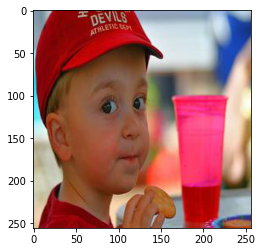

<start> a young boy wearing a blue shirt and a blue shirt is playing with a ball . <end>


In [38]:
import matplotlib.pyplot as plt

image = Image.open(image_path)
plt.imshow(np.asarray(image))
plt.show()
print(sentence)